In [3]:
# Remove # to install dependencies if you need them
#!pip install torch torchvision
#!pip install livelossplot


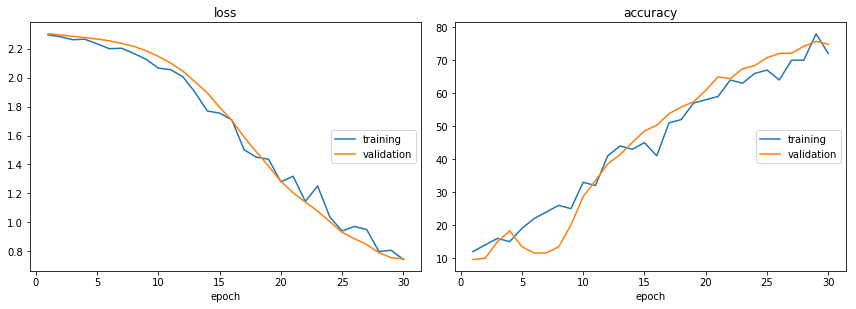

loss:
training   (min:    0.743, max:    2.296, cur:    0.743)
validation (min:    0.748, max:    2.304, cur:    0.748)

accuracy:
training   (min:   12.000, max:   78.000, cur:   72.000)
validation (min:    9.585, max:   75.711, cur:   74.820)


In [22]:
################################
## Imports
################################
from __future__ import print_function
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# livelossplot requires inline matplotlib
from livelossplot import PlotLosses
%matplotlib inline


################################
## Constants
################################

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()

args.seed = 321
args.batch_size = 100
args.test_batch_size = 64
args.epochs = 3
args.lr = 0.03
args.momentum = 0.5
args.log_interval = 5

mnist_mean = 0.1307
mnist_std = 0.3081

torch.manual_seed(args.seed)

################################
## NN Architecture
################################

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

################################
## Functions
################################

def get_correct_count(output, target):
    _, indexes = output.data.max(1, keepdim=True)
    return indexes.eq(target.data.view_as(indexes)).cpu().sum().item()

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    seen = 0
    for data, target in test_loader:
        data = Variable(data)
        target = Variable(target)
        # `no_grad` so we don't use these calculations in backprop
        with torch.no_grad():
            output = model(data)
            seen += len(output)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            
            # get the index of the max log-probability
            correct += get_correct_count(output, target)

    test_loss /= seen
    accuracy = correct * 100.0 / seen
    print(
       '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
           test_loss, correct, seen,
           100. * correct / seen))
    return test_loss, accuracy

def train(model, optimizer, epoch, train_loader, test_loader):
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        train_loss = F.nll_loss(output, target)
        train_loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            with torch.no_grad():
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                   epoch, batch_idx, len(train_loader),
                   100. * batch_idx / len(train_loader), train_loss.item()))
                test_loss, test_accuracy = test(model, test_loader)
                train_accuracy = get_correct_count(output, target) * 100.0 / len(target)
                logs = {
                    'val_loss': test_loss,
                    'loss': train_loss,
                    'accuracy': train_accuracy,
                    'val_accuracy': test_accuracy
                }
                liveloss.update(logs)
                liveloss.draw()

            
def get_train_test():
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            './data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((mnist_mean, ), (mnist_std, ))
            ])),
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            './data',
            train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((mnist_mean, ), (mnist_std, ))
            ])),
        batch_size=args.test_batch_size,
        shuffle=True,
        drop_last=True)
    
    return train_loader, test_loader

################################
## Main Execution
################################
liveloss = PlotLosses()

def main():
    # Get Data
    train_loader, test_loader = get_train_test()

    # instatiate NN model
    model = SimpleNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr)#, momentum=args.momentum)

    first_batch = next(iter(train_loader))

    for epoch in range(args.epochs):
        #train(model, optimizer, epoch, [first_batch] * 50, [first_batch])
        train(model, optimizer, epoch, [first_batch] * 50, test_loader)
        #train(model, optimizer, epoch, train_loader, test_loader)
        #test(test_loader)
    
    return model

trained_model = main()

# Plotting and Analyzing

In [1]:
# Make sure matplotlib knows it's going into a notebook
import matplotlib.pyplot as plt


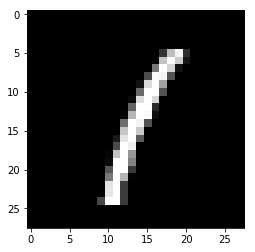

In [50]:
# for batch_idx, (data, target) in enumerate(train_loader):
%matplotlib inline
train_loader, test_loader = get_train_test()
first_batch = next(iter(train_loader))
plt.imshow(first_batch[0][5][0,:,:]);
#n[0][0][0].shape

In [29]:
n[0][0][0][0,:,:].shape

torch.Size([28, 28])

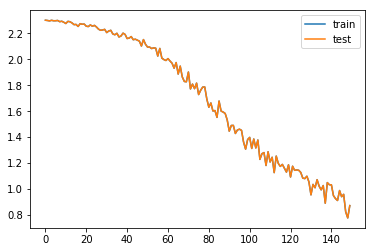

In [7]:
# perf = [ [], [] ]
#                 perf[0].append(train_loss)
#                 perf[1].append(test_loss)

import matplotlib.pyplot as plt
plt.plot(perf[0], label='train')
plt.plot(perf[0], label='test')
plt.gca().legend()

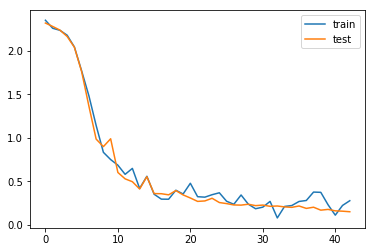

In [47]:
plt.plot(perf[0], label='train')
plt.plot(perf[1], label='test')
plt.gca().legend()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


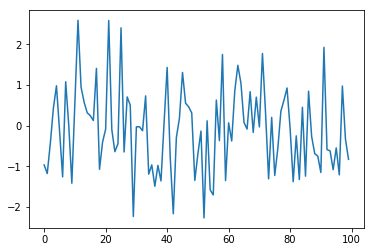

In [85]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
#matplotlib.use('nbagg')

import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    #plt.clear()
    #plt.plot([0, 0.5, np.random.normal(0,1,1)[0], 0.9, 1.0])
    fig.canvas.draw()
    print(i)


In [12]:
%matplotlib inline
import matplotlib
#matplotlib.use('MacOSX')
#matplotlib.use('nbAgg')

import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    # Convert to numpy so imshow doesn't have to
    npimg = img.numpy()
    # Unnormalize because imshow requires [0..1] for floats, neural nets require [-1..1]
    #img = (img + 1) / 2 # Not valid because normalization is dividing by STD not MAX.
    npimg = (npimg - npimg.min()) / npimg.ptp()
    # PyTorch uses (channels, height, width), Imshows uses (height, width, channels)
    imshow_img = np.transpose(npimg, (1, 2, 0))
    max_res = 2048
    fig_shape = (min(imshow_img.shape[0], max_res), min(imshow_img.shape[1], max_res))
    print("fig_shape", fig_shape)
    fig = plt.figure(figsize = fig_shape)
    print("figged")
    plt.imshow(imshow_img)
    print("imshowed")
    plt.show()
    print("showed")
#     from IPython.core.display import Image, display
#     #display(Image('https://i.ytimg.com/vi/j22DmsZEv30/maxresdefault.jpg', width=1900, unconfined=True))
#     display(Image(imshow_img))



train_loader, test_loader = get_train_test()
first_batch = next(iter(train_loader))
#some_ims = [np.array(im[0,:,:]) for im in first_batch[0][:5]]
two = []
for i, (data, target) in enumerate(train_loader):
    if i > 3:
        break
    two += list(data)
grid_image = torchvision.utils.make_grid(two[:96], normalize=True)
print("grid shape", grid_image.shape)
imshow(grid_image)


grid shape torch.Size([3, 362, 242])


ValueError: ndarray is not C-contiguous

ValueError: ndarray is not C-contiguous

<IPython.core.display.Image object>

TypeError: Invalid dimensions for image data

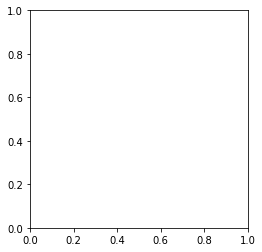

In [13]:
for im in two:
    plt.figure()
    plt.imshow(im)


<IPython.core.display.Javascript object>


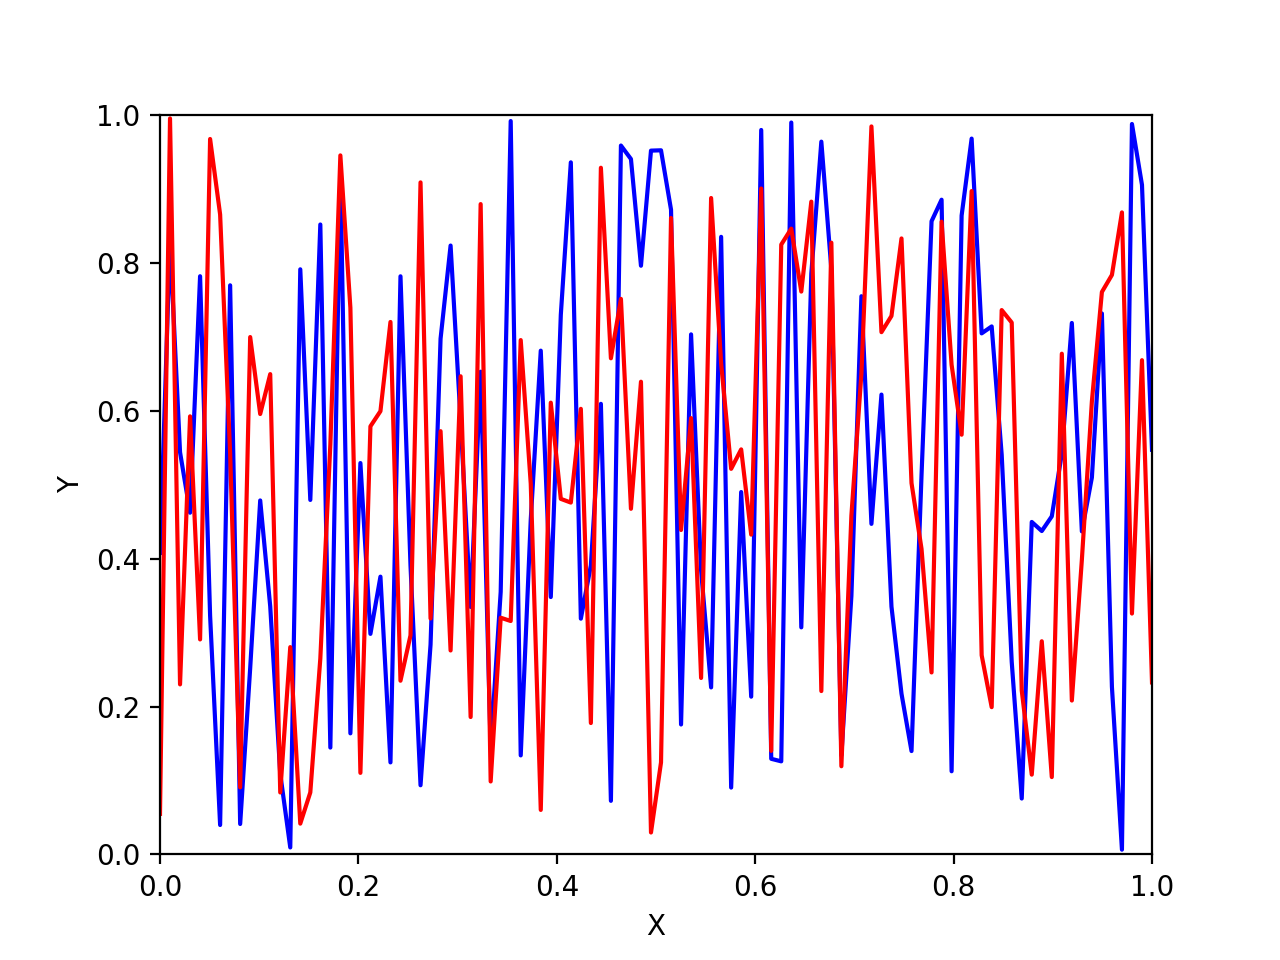

In [4]:
%matplotlib notebook
import time
import matplotlib.pyplot as plt
import numpy as np
def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)

In [25]:
# Trying to visualize weights
import torch
import torchvision.models as models
from matplotlib import pyplot as plt

def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
  
#vgg = models.vgg16(pretrained=True)
#mm = vgg.double()
filters = trained_model.modules
body_models = [i for i in trained_model.children()]
layer1 = body_models[0]
tensor = layer1.weight.data.numpy()
plot_kernels(tensor)
# body_model.weight.data.numpy()
tensor.shape #(10, 1, 5, 5)


Exception: last dim needs to be 3 to plot

In [19]:
import plotly.graph_objs as go

data = [go.Bar(
            x=['giraffes', 'orangutans', 'monkeys'],
            y=[20, 14, 23]
    )]
layout = {'yaxis': {'range': [0, 25]}}
fig = go.FigureWidget(data, layout)
fig


FigureWidget({
    'data': [{'type': 'bar',
              'uid': '16bfb628-160d-49a2-84d7-a035358a4738',
     …

In [23]:
!pip list

Package                            Version   
---------------------------------- ----------
adal                               1.2.0     
alabaster                          0.7.12    
anaconda-client                    1.7.2     
anaconda-navigator                 1.9.6     
anaconda-project                   0.8.2     
antlr4-python3-runtime             4.7.2     
applicationinsights                0.11.7    
appnope                            0.1.0     
appscript                          1.0.1     
argcomplete                        1.9.4     
asn1crypto                         0.24.0    
astroid                            2.1.0     
astropy                            3.1       
atomicwrites                       1.2.1     
attrs                              18.2.0    
avro-python3                       1.8.2     
azure-cli-core                     2.0.48    
azure-cli-nspkg                    3.0.3     
azure-cli-telemetry                1.0.0     
azure-common                      

Pygments                           2.3.1     
PyJWT                              1.7.1     
pylint                             2.2.2     
PyNaCl                             1.3.0     
pyodbc                             4.0.25    
pyOpenSSL                          18.0.0    
pyparsing                          2.3.0     
PySocks                            1.6.8     
pytest                             4.0.2     
pytest-arraydiff                   0.3       
pytest-astropy                     0.5.0     
pytest-doctestplus                 0.2.0     
pytest-openfiles                   0.3.1     
pytest-remotedata                  0.3.1     
python-dateutil                    2.7.5     
pytz                               2018.7    
PyWavelets                         1.0.1     
PyYAML                             3.13      
pyzmq                              17.1.2    
QtAwesome                          0.5.3     
qtconsole                          4.4.3     
QtPy                              

In [26]:
train_loader[0]

TypeError: 'DataLoader' object does not support indexing